# over- and under-splitting analysis of snmC2T-seq

Fangming Xie, updated on 5/11/2020

In this notebook, we examplify how one can evaluate the level of over- and under-splitting of a given clustering, by taking advantage of a single-cell multi-modal sequencing dataset--snmC2T-seq.

We will embed cells from 2 different modalities (mC and RNA) into the same low-dimensional space using canonical correlation analysis. Combining the cell-cell distance in that embedding and the information that cells in the 2 modalities are actually matched--they are measured by snmC2T-seq with both mC and RNA information, we develop metrics to visualize and evaluate the level of under-split or over-split of a cell cluster.

Clustering is in part an art of choosing a side between lumpers and splitters. When a clustering is too refined, it is at risk of over-splitting; on the other hand, when it is too broad, it is at risk of over-lumping (under-splitting). We reason that an ideal cluster should be ideal in two ways: 1. it should be locally homogenous such that no further split can be applied to. 2. it should be globally distinct such that cells in it will not be mislabeled as belonging to its neighboring clusters. In reality, however, there is a trade-off between the 2 properties. All of these and more will be shown concretely by the following code and plots.




In [1]:
import sys
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import sparse
from scipy import stats
from sklearn.metrics.pairwise import euclidean_distances
import collections
import itertools
import re
import fbpca
import datetime
import json

# in-house generated scripts
from __init__ import *
from __init__plot import *
import general_utils
import knn_utils

## Prepare the analysis

In [2]:
timestamp = datetime.datetime.now().date()
name = 'mctseq_over_under_split_{}'.format(timestamp)
output_figures = './results/figures/{}_{{}}.{{}}'.format(name)

DATA_DIR = './data'
sys.path.insert(0, DATA_DIR)
from __init__datasets import *

mods_selected = [
    'human_frontal_rna',
    'human_frontal_mch',
    ]
mod_i, mod_j = 'human_frontal_rna', 'human_frontal_mch'

### Load data
- metadata
- feature matrix (gene-by-cell; genes are pre-selected highly correlated genes between modalities)

In [3]:
np.random.seed(0)

In [4]:
# within modality smoothing parameters
ps = {'mc': 0.9,
      'rna': 0.7,
     }
drop_npcs = {
    'mc': 0,
    'rna': 0,
    }

In [5]:
# load cell level metedata
meta_f = os.path.join(DATA_DIR, '{0}_metadata.tsv')
metas = collections.OrderedDict()

for mod in mods_selected:
    metas[mod] = pd.read_csv(meta_f.format(mod), sep="\t").reset_index().set_index(settings[mod].cell_col)
    print(metas[mod].iloc[:1, :2], len(metas[mod]))

# load palette and meta settings 
cluster_col_major = 'ClusterAnno'
cluster_col_sub = 'SubClusterAnno'

f = './palette/modality_palette.json'
mod_colors = json.load(open(f), object_pairs_hook=collections.OrderedDict)    
mod_colors['human_frontal_mch'] = mod_colors['mCH']
mod_colors[settings['human_frontal_mch'].name] = mod_colors['mCH']
mod_colors['human_frontal_rna'] = mod_colors['RNA']
mod_colors[settings['human_frontal_rna'].name] = mod_colors['RNA']

f = './palette/sub_cluster_palette.json'
subtype_colors = json.load(open(f), object_pairs_hook=collections.OrderedDict)    
subtype_ranks = collections.OrderedDict({key: i for i, (key, val) in enumerate(subtype_colors.items())})

f = './palette/major_cluster_palette.json'
majortype_colors = json.load(open(f), object_pairs_hook=collections.OrderedDict)    
majortype_ranks = collections.OrderedDict({key: i for i, (key, val) in enumerate(majortype_colors.items())})

for mod in mods_selected:
    metas[mod]['majortype_rank'] = metas[mod][cluster_col_major].apply(lambda x: majortype_ranks[x])
    metas[mod]['subtype_rank'] = metas[mod][cluster_col_sub].apply(lambda x: subtype_ranks[x])
    
    
# major sub lookup and sub major lookup
major_clsts = np.sort(metas[mod_i][cluster_col_major].unique())
sub_clsts = np.sort(metas[mod_i][cluster_col_sub].unique())

major_sub_lookup = collections.OrderedDict({clst: [] for clst in major_clsts})
for clst in sub_clsts:
    prefix = '_'.join(clst.split('_')[:-1])
    major_sub_lookup[prefix].append(clst)
sub_major_lookup = collections.OrderedDict({clst: '_'.join(clst.split('_')[:-1]) for clst in sub_clsts})

                                   index  Technology
sample                                              
UMB5577_1_UMB5577_2_A10_AD001_rna      0  snmCT-NOMe 3898
                                   index  Technology
sample                                              
UMB5577_1_UMB5577_2_A10_AD001_mch      0  snmCT-NOMe 3898


In [6]:
# load feature matrices
hvftrs_f = os.path.join(DATA_DIR, '{0}_hvfeatures.{1}')
hvftrs_gene = os.path.join(DATA_DIR, '{0}_hvfeatures.gene')
hvftrs_cell = os.path.join(DATA_DIR, '{0}_hvfeatures.cell')

gxc_hvftrs = collections.OrderedDict()
for mod in mods_selected:
    print(mod)
    ti = time.time()
    
    if settings[mod].mod_category == 'mc':
        f_mat = hvftrs_f.format(mod, 'tsv')
        gxc_hvftrs[mod] = pd.read_csv(f_mat, sep='\t', header=0, index_col=0) 
        
        # subsample
        gxc_hvftrs[mod] = gxc_hvftrs[mod][metas[mod].index.values]
        
        print(gxc_hvftrs[mod].shape, time.time()-ti)
        assert np.all(gxc_hvftrs[mod].columns.values == metas[mod].index.values) # make sure cell name is in the sanme order as metas (important if save knn mat)
        continue
        
    f_mat = hvftrs_f.format(mod, 'npz')
    f_gene = hvftrs_gene.format(mod)
    f_cell = hvftrs_cell.format(mod)
    
    _mat = sparse.load_npz(f_mat) 
    _gene = pd.read_csv(f_gene, sep='\t', header=None).iloc[:, 0].values
    _cell = pd.read_csv(f_cell, sep='\t', header=None).iloc[:, 0].values 
    
    gxc_hvftrs[mod] = GC_matrix(_gene, _cell, _mat)
    assert np.all(gxc_hvftrs[mod].cell == metas[mod].index.values) # make sure cell name is in the sanme order as metas (important if save knn mat)
    print(gxc_hvftrs[mod].data.shape, time.time()-ti)

human_frontal_rna
(5107, 3898) 1.2867205142974854
human_frontal_mch
(5107, 3898) 5.300251007080078


In [7]:
# GENE by CELL
smoothed_features = collections.OrderedDict()
for mod in mods_selected:
    print(mod)
    ti = time.time()
    
    if settings[mod].mod_category == 'mc':
        _df = gxc_hvftrs[mod]
    else:
        _mat = gxc_hvftrs[mod].data.todense()
        _df = pd.DataFrame(_mat, 
                          index=gxc_hvftrs[mod].gene, 
                          columns=gxc_hvftrs[mod].cell, 
                          ) 
        
    mat_smoothed, mat_knn = general_utils.smooth_in_modality(_df, _df, k=30, ka=5, npc=50, 
                                               p=ps[settings[mod].mod_category], 
                                               drop_npc=drop_npcs[settings[mod].mod_category])
    smoothed_features[mod] = mat_smoothed
    print(smoothed_features[mod].shape)
    print(time.time() - ti)

human_frontal_rna
Time used to build kNN map 0.05033707618713379
Time used to get kNN 0.1320209503173828
(5107, 3898)
1.5209581851959229
human_frontal_mch
Time used to build kNN map 0.05206704139709473
Time used to get kNN 0.12839698791503906
(5107, 3898)
1.0324022769927979


### Load integrated cell embedding

In [8]:
f = './data/integrated_clustering_and_embedding.tsv'
df_info = pd.read_csv(f, sep="\t", index_col='sample') 
df_info = df_info.rename({
                          'tsne_x': 'tsne_x_joint',
                          'tsne_y': 'tsne_y_joint',
                         }, axis=1)
df_info['modality_name'] = df_info['modality'].apply(lambda mod: settings[mod].name)

# add cluster, annot info
for mod in mods_selected:
    _cells = metas[mod].index.values
    df_info.loc[_cells, 'cluster'] = metas[mod].loc[_cells, settings[mod].cluster_col]
    df_info.loc[_cells, 'annot'] = metas[mod].loc[_cells, settings[mod].annot_col]
    df_info.loc[_cells, 'sub_cluster'] = metas[mod].loc[_cells, settings[mod].cluster_col_sub]
    df_info.loc[_cells, 'sub_annot'] = metas[mod].loc[_cells, settings[mod].annot_col_sub]

print(df_info.shape)
df_info.head()

(7796, 10)


,modality,cluster_joint_r0.3,cluster_joint_r4,tsne_x_joint,tsne_y_joint,modality_name,cluster,annot,sub_cluster,sub_annot
sample,,,,,,,,,,
UMB5577_1_UMB5577_2_A10_AD001_rna,human_frontal_rna,2,2,-7.315885,0.850225,mCT - RNA,Exc_L2-4_RORB,Exc_L2-4_RORB,Exc_L2-4_RORB_-,Exc_L2-4_RORB_-
UMB5577_1_UMB5577_2_A10_AD002_rna,human_frontal_rna,1,8,-3.863784,8.486494,mCT - RNA,Exc_L1-3_CUX2,Exc_L1-3_CUX2,Exc_L1-3_CUX2_SLC35F3,Exc_L1-3_CUX2_SLC35F3
UMB5577_1_UMB5577_2_A10_AD004_rna,human_frontal_rna,7,6,12.818132,-5.993275,mCT - RNA,Inh_MGE_PVALB,Inh_MGE_PVALB,Inh_MGE_PVALB_DISC1,Inh_MGE_PVALB_DISC1
UMB5577_1_UMB5577_2_A10_AD006_rna,human_frontal_rna,8,24,14.620861,1.303185,mCT - RNA,Inh_MGE_B3GAT2,Inh_MGE_B3GAT2,Inh_MGE_B3GAT2_AOAH,Inh_MGE_B3GAT2_AOAH
UMB5577_1_UMB5577_2_A10_AD007_rna,human_frontal_rna,12,16,-5.217489,-8.968289,mCT - RNA,Exc_L5-6_PDZRN4,Exc_L5-6_PDZRN4,Exc_L5-6_PDZRN4_RGS6,Exc_L5-6_PDZRN4_RGS6


In [9]:
centroids = {}
_x = (df_info[['tsne_x_joint', 'tsne_y_joint', 'annot', 'modality']]
             .groupby(['modality', 'annot']).median())
for mod in mods_selected:
    centroids[mod] = _x.loc[mod, :]

### Plot cell embeddings colored by modality and clusterings 

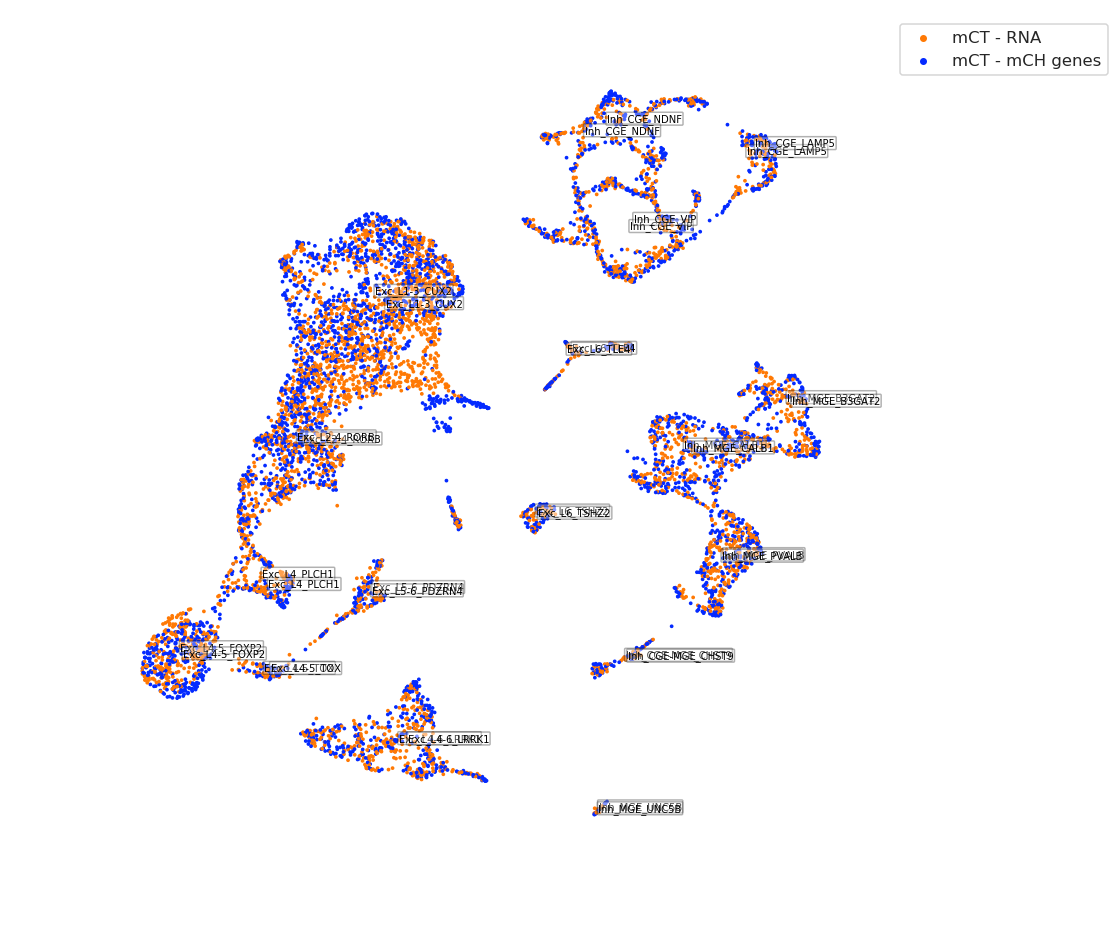

In [10]:
# plot joint embedding colored by modality

fig, ax = plt.subplots(1, 1, figsize=(16*1,16*1))
tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'modality_name'
legend_kws = {'bbox_to_anchor': (1, 1), 'loc': 'upper left'}
general_utils.plot_tsne_labels_ax(df_info, ax, tx, ty, tc, 
                                  legend_kws=legend_kws,
                                  legend_size=30,
                                  rasterized=True,
                                  kw_colors=mod_colors,
                                  s=5,
                                 )
ax.set_aspect('equal')
ax.set_title('')
ax.axis('off')

# add labels
for mod in mods_selected:
    for clst, centroid in centroids[mod].iterrows():
        facecolor='white'
        ax.text(centroid.values[0], 
                centroid.values[1], 
                clst,
                color='black', 
                bbox=dict(facecolor=facecolor, alpha=0.3, edgecolor='black', boxstyle='round,pad=0.1'),
                fontsize=10,
               )

fig.savefig(output_figures.format(2, 'pdf'), bbox_inches='tight', dpi=300)
plt.show()

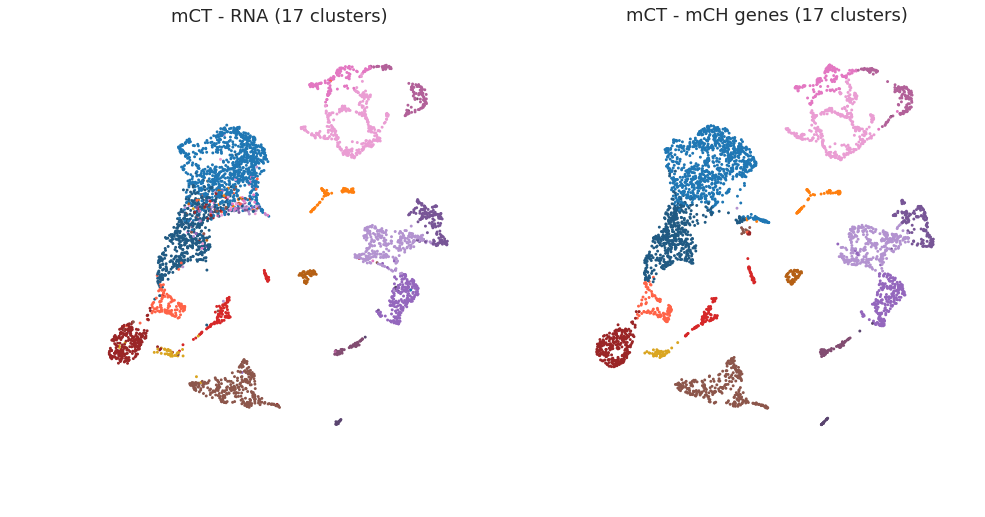

In [11]:
# plot joint embedding colored by major clusters  
n = len(mods_selected)
nx = 2
ny = int((n+nx-1)/nx)
fig, axs = plt.subplots(ny, nx, figsize=(8*nx,8*ny))
axs = axs.flatten()
tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'annot'

for ax, mod in zip(axs, mods_selected):
    general_utils.plot_tsne_labels_ax(df_info[df_info['modality']==mod], ax, tx, ty, tc, 
                                      legend_mode=-1,
                                      rasterized=True,
                                      kw_colors=majortype_colors,
                                      s=2,
                                     )
    ax.set_title('{} ({} clusters)'.format(settings[mod].name, len(df_info.loc[df_info['modality']==mod, tc].unique())))
    ax.set_aspect('equal')
    ax.axis('off')
for ax in axs[n:]:
    ax.axis('off')
    

fig.savefig(output_figures.format('3-major', 'pdf'), bbox_inches='tight', dpi=300)
plt.show()
    

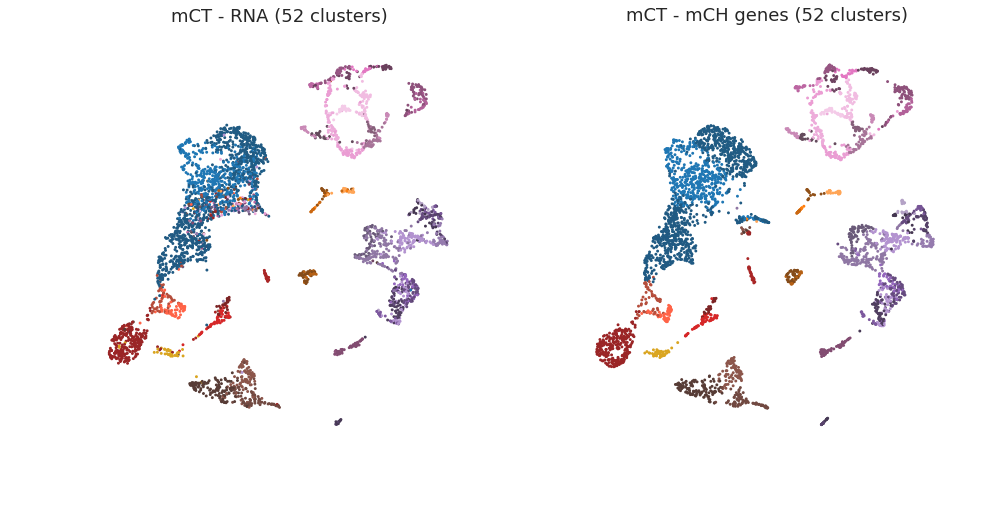

In [12]:
# plot joint embedding colored by sub-clusters  
n = len(mods_selected)
nx = 2
ny = int((n+nx-1)/nx)
fig, axs = plt.subplots(ny, nx, figsize=(8*nx,8*ny))
axs = axs.flatten()
tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'sub_annot'

for ax, mod in zip(axs, mods_selected):
    general_utils.plot_tsne_labels_ax(df_info[df_info['modality']==mod], ax, tx, ty, tc, 
                                      legend_mode=-1,
                                      rasterized=True,
                                      kw_colors=subtype_colors,
                                      s=2,
                                     )
    ax.set_title('{} ({} clusters)'.format(settings[mod].name, len(df_info.loc[df_info['modality']==mod, tc].unique())))
    ax.set_aspect('equal')
    ax.axis('off')
for ax in axs[n:]:
    ax.axis('off')
    

fig.savefig(output_figures.format('3-sub', 'pdf'), bbox_inches='tight', dpi=300)
plt.show()
    

## Over- and under-splitting analysis

In [13]:
def get_self_radius(distances, axis=1):
    """Get self-radius from a distance matrix (with row and col in the same order)
    Args:
        - distance - 2d matrix
        - axis 1 - row self-radius (for each row, its pair ranking in col)
    return:
        - 
    """
    return np.diag(pd.DataFrame(distances).rank(axis=axis))

def reduce_dim_cca(X, Y, k): 
    """Reduce dim 
    Args:
        - X  cell by features
        - Y  
        features needs to be matched between X and Y
    Return:
        - U   cell by features
        - V (Vt.T)
    """
    X = np.array(X)
    Y = np.array(Y)
    U, s, Vt = fbpca.pca(X.dot(Y.T), k=k)
    return U, Vt.T

def shuffle_matrix(X, metadata, groupby_col):
    """Shuffle X according to groups in metadata
    Args:
        - X: dataframe cell by gene 
        - metadata: dataframe cell by groups
    Return:
        - X_shuffled: dataframe cell by gene 
    """
    # begin gene by cell
    X = X.T # gene by cell
    
    cells_all = []
    shuffled_data_all = []
    for clst, df_sub in metadata.groupby(groupby_col):
        cells_sub = df_sub.index.values
        cells_all += cells_sub.tolist()

        shuffled_data_tmp = []
        for i, gene_row in enumerate(X[cells_sub].values):
            gene_row_shuffled = np.random.permutation(gene_row)
            shuffled_data_tmp.append(gene_row_shuffled)
        shuffled_data_tmp = np.array(shuffled_data_tmp)
        shuffled_data_all.append(shuffled_data_tmp)

    shuffled_data_all = np.hstack(shuffled_data_all)
    X_shuffled = pd.DataFrame(shuffled_data_all, index=X.index, columns=cells_all)[metadata.index.values]
    ## end gene by cell
    
    X_shuffled = X_shuffled.T # cell by gene
    return X_shuffled

def shuffle_celllabels(X):
    """Shuffle X (rwos) 
    Args:
        - X: dataframe cell by gene 
        - metadata: dataframe cell by groups
    Return:
        - X_shuffled: dataframe cell by gene 
    """
    X_shuffled = pd.DataFrame(np.random.permutation(X.values),
                              index=X.index, 
                              columns=X.columns,
                             )
    return X_shuffled

In [14]:
class DatasetPair:
    def __init__(self, mod_i, mod_j, mat_i, mat_j, direct_i, direct_j,):
        """mat_i and mat_j are cell by gene matricies
        """
        assert np.all(mat_i.columns.values == mat_j.columns.values)
        self.genes = mat_i.columns.values
        self.cells_i = mat_i.index.values
        self.cells_j = mat_j.index.values
        
        self.mod_i = mod_i
        self.mod_j = mod_j
        self.mat_i = mat_i
        self.mat_j = mat_j
        self.direct_i = direct_i
        self.direct_j = direct_j
        
    def _normalize(self):
        """Generate zscored (by gene) feature matrix and flip sign for DNA methylation
        add:
         - self.mat_norm_i
         - self.mat_norm_j
        """
        self.mat_norm_i = self.mat_i.apply(general_utils.zscore, axis=1)*self.direct_i
        self.mat_norm_j = self.mat_j.apply(general_utils.zscore, axis=1)*self.direct_j
    
    def _coembed(self, k=20):
        """Embed cells from the 2 datasets (zscored) into a low dimentional (k=20) CCA space
        add: 
         - self.mat_cca_i
         - self.mat_cca_j
        """
        self.mat_cca_i, self.mat_cca_j = reduce_dim_cca(self.mat_norm_i, self.mat_norm_j, k=k)
        
    def _cross_mod_knn(self, knn_max):
        """Get k-nearest-neighbors (up to knn_max) of each cell from the other dataset
        add: 
         - self.knn_ji_grand: for each cell in j get kNN in i
         - self.knn_ij_grand: for each cell in i get kNN in j
        """
        # knn
        self.knn_ji_grand = knn_utils.gen_knn_annoy_train_test(
                                                                self.mat_cca_i, # look for nearest neighbors in i 
                                                                self.mat_cca_j, # for each row in j
                                                                knn_max,
                                                                form='list', # adj matrix 
                                                                verbose=False,
                                                                ).astype(int)
        self.knn_ij_grand = knn_utils.gen_knn_annoy_train_test(
                                                                self.mat_cca_j, # look for nearest neighbors in j 
                                                                self.mat_cca_i, # for each row in i
                                                                knn_max,
                                                                form='list', # adj matrix 
                                                                verbose=False,
                                                                ).astype(int)
        
    def _cross_mod_distance(self):
        """Get cross modality distance matrix 
        add:
         - self.distances: (num_cells_i, num_cells_j)
        """
        # distances
        self.distances = euclidean_distances(self.mat_cca_i, self.mat_cca_j)
        
    def _self_radius(self):
        """Get the self-radius for each cell
        add: 
         - self.rankings_i: rankings for each cell in i
         - self.rankings_j: rankings for each cell in j
        """
        # self-radius
        self.rankings_i = get_self_radius(self.distances, axis=1) # for each i, its pair ranking in j
        self.rankings_j = get_self_radius(self.distances, axis=0) # for each j, its pair ranking in i
    
    def compute_cross_mod_metrics(self, knn_max):
        """Compute all cross modality related metrics
        """
        self._normalize()
        self._coembed()
        self._cross_mod_knn(knn_max)
        self._cross_mod_distance()
        self._self_radius()

### Embed mC and RNA cells into the same embedding, calculate distances, k-nearest-neighbors, and self-radius between them

we perform the same analysis for 4 sets of dataset pairs:
- The original mC and RNA datasets as measured by snmC2T-seq
- The mC and RNA datasets with shuffled gene features for each gene within defined cell types (2 levels: 17 major types and 52 sub types) (so that the within-cluster heterogeneities are destroyed).
- The mC and RNA datasets with shuffled cell labels (so that the cluter labels are destroyed).

2 key concepts:
**self radius**--number of cross-modality k nearest neighbors a cell needs to find itself in the other modality. We can evaluate under-splitting based on it.
**fraction of cross-modality neighbors from the same cell types**. We can evaluate over-splitting based on it.


In [15]:
knn_max = 1000

mat_ii = smoothed_features[mod_i].T
mat_jj = smoothed_features[mod_j].T
direct_i = settings[mod_i].mod_direction
direct_j = settings[mod_j].mod_direction

In [16]:
# original data
orig_data_pair = DatasetPair(mod_i, mod_j, mat_ii, mat_jj, direct_i, direct_j)
orig_data_pair.compute_cross_mod_metrics(knn_max)

In [17]:
# shuffled genes within major subtypes 
mat_i_shuffled = shuffle_matrix(mat_ii, metas[mod_i], cluster_col_major)
mat_j_shuffled = shuffle_matrix(mat_jj, metas[mod_j], cluster_col_major)
shuffled_by_majortype_data_pair = DatasetPair(mod_i, mod_j, mat_i_shuffled, mat_j_shuffled, direct_i, direct_j)
shuffled_by_majortype_data_pair.compute_cross_mod_metrics(knn_max)

# shuffled genes within subtypes
mat_i_shuffled = shuffle_matrix(mat_ii, metas[mod_i], cluster_col_sub)
mat_j_shuffled = shuffle_matrix(mat_jj, metas[mod_j], cluster_col_sub)
shuffled_by_subtype_data_pair = DatasetPair(mod_i, mod_j, mat_i_shuffled, mat_j_shuffled, direct_i, direct_j)
shuffled_by_subtype_data_pair.compute_cross_mod_metrics(knn_max)

# shuffle3: shuffle cell cluster labels
mat_i_shuffled = shuffle_celllabels(mat_ii)
mat_j_shuffled = shuffle_celllabels(mat_jj)
shuffledCelllabel_data_pair = DatasetPair(mod_i, mod_j, mat_i_shuffled, mat_j_shuffled, direct_i, direct_j)
shuffledCelllabel_data_pair.compute_cross_mod_metrics(knn_max)

### Under-splitting evaluation--Plot the cumulative distributions of self-radius for different clusters and shuffled clusters  

In [18]:
def compute_area(x, y, xstart, xend, bins=100):
    """
    """
    bins = 100
    width = (xend - xstart)/bins
    xeval = np.linspace(xstart, xend, bins)
    yeval = np.interp(xeval, x, y)
    area = np.trapz(yeval, x=xeval, dx=width)
    return area

def gather_self_radius_info(choose_mod, metadata, cluster_col, data_pairs):
    """
    input:
        choose_mod is a string 'mod_i' or mod_j'
        metadata is a dataframe indexed by cell_id 
                      and contains a column cluster_col indicating the cluster assignment of each cell
        data_pairs are a dictionary of the DatasetPair object
        assuming all data pairs have the same genes and cells (2 pairs)
    output:
        cell_level_info - dataframe with cell, cluster, cluster_size, self_radius for the choose_mod of each data pair
        cluster_level_info - dataframe with cluster level stats
    
    """
    assert choose_mod in ['mod_i', 'mod_j']
    
    cells = metadata.index.values
    cluster_lookup = metadata[cluster_col].values
    cluster_size_lookup = metadata.groupby(cluster_col).size()
    
    cell_level_info = pd.DataFrame()
    cell_level_info['clst_id'] = cluster_lookup
    cell_level_info['n_clst_size'] = cluster_size_lookup.loc[cluster_lookup].values
    
    for datapair_type, datapair in data_pairs.items():
        if choose_mod == 'mod_i':
            assert np.all(cells == datapair.cells_i)
            self_radius = datapair.rankings_i
        elif choose_mod == 'mod_j':
            assert np.all(cells == datapair.cells_j)
            self_radius = datapair.rankings_j
        else:
            raise ValueError('choose from mod_i and mod_j')
        cell_level_info['n_self_radius_{}'.format(datapair_type)] = self_radius.astype(int)
        
    cluster_level_info = [] 
    for clst_id, df_sub in cell_level_info.groupby('clst_id'):
        clst_size = df_sub['n_clst_size'].iloc[0]
        cluster_level_info_1row = {
            'clst_id': clst_id, 
            'cluster_size': clst_size, 
            }
        for datapair_type in data_pairs.keys():
            xcol = 'n_self_radius_{}'.format(datapair_type)
            ## scores
            # num
            num = (df_sub[xcol] < clst_size).sum() # y(1)
            frac = num/clst_size
            # calculate area
            x = df_sub[xcol].sort_values().values/clst_size # self_radius
            y = np.arange(len(x))/len(x)
            area = compute_area(x, y, 0, 1, bins=100)
            # calculate half rate
            xhalf = np.interp(0.5*frac, y, x)
            # calculate slope at y(0.25)
            x_eval = 0.25
            slope25 = np.interp(x_eval, x, y)/x_eval
            x_eval = 0.5
            slope50 = np.interp(x_eval, x, y)/x_eval

            cluster_level_info_1row['num1_'+datapair_type] = num
            cluster_level_info_1row['frac1_'+datapair_type] = frac
            cluster_level_info_1row['area1_'+datapair_type] = area
            cluster_level_info_1row['xhalf_'+datapair_type] = xhalf
            cluster_level_info_1row['slope25_'+datapair_type] = slope25
            cluster_level_info_1row['slope50_'+datapair_type] = slope50

        cluster_level_info.append(cluster_level_info_1row)
    cluster_level_info = pd.DataFrame(cluster_level_info)
    
    return cell_level_info, cluster_level_info

In [19]:
def plot_self_radius(cell_level_info, colors, output=''):
    """
    clst_id, n_clst_size, n_self_radius_$datapair_type1, ...
    """
    
    
    cols = cell_level_info.filter(regex='^n_self_radius_', axis=1).columns.values
    ncols = len(cols)
    nclsts = len(cell_level_info['clst_id'].unique())
    assert len(colors) == ncols
    
    fig, axs = plt.subplots(1, ncols, figsize=(6*ncols,6), sharex=True, sharey=True)
    xlim = 2
    xbins = np.linspace(0, xlim, 50)
    ybins_agg = {}
    for i, (clst_id, df_sub) in enumerate(cell_level_info.groupby('clst_id')):
        clst_size = df_sub['n_clst_size'].iloc[0]
        for xcol, ax in zip(cols, axs):
            if i == 0:
                ybins_agg[xcol] = []
            
            x = df_sub[xcol].sort_values().values/clst_size
            y = np.arange(len(x))/len(x)
            ax.plot(x, y, label=clst_id, color='grey', alpha=0.3, zorder=1)
            
            ybins = np.interp(xbins, x, y)
            ybins_agg[xcol].append(ybins)
            
        ax.set_xlabel("Self-radius/Cluster_size")
        
    ybins_mean = {}
    ybins_err = {}
    for xcol, ax, color in zip(cols, axs, colors):
        ybins_agg[xcol] = np.array(ybins_agg[xcol])
        ybins_mean = ybins_agg[xcol].mean(axis=0)
        ybins_err = 1.96*ybins_agg[xcol].std(axis=0)/np.sqrt(nclsts)
        
        ax.plot(xbins, ybins_mean, color=color, zorder=2, linewidth=3)
        ax.fill_between(xbins, 
                        ybins_mean-ybins_err, 
                        ybins_mean+ybins_err, 
                        color=color, alpha=0.4, zorder=2)
        ax.set_title(xcol[len('n_self_radius_'):])
    ax.set_xlim([0, xlim])
    axs[0].set_ylabel(r"Cumulative fraction of cells")
    
    if output:
        fig.savefig(output, bbox_inches='tight')
    plt.show()
    
def plot_self_radius_mean(ax, cell_level_info, colors, xcols, xcol_names, output=''):
    """
    """
    assert len(xcols) == len(xcol_names)
    
    nclsts = len(cell_level_info['clst_id'].unique())
    xlim = 2
    xbins = np.linspace(0, xlim, 50)
    ybins_agg = {}
    
    x = [0, 1, 2]
    y = [0, 1, 1]
    ax.plot(x, y, '--', 
            color='k', 
            label='Ideal cluster'
           )
    
    for i, (clst_id, df_sub) in enumerate(cell_level_info.groupby('clst_id')):
        clst_size = df_sub['n_clst_size'].iloc[0]
        for xcol, xcol_name in zip(xcols, xcol_names):
            if i == 0:
                ybins_agg[xcol] = []
            
            x = df_sub[xcol].sort_values().values/clst_size
            y = np.arange(len(x))/len(x)
            ybins = np.interp(xbins, x, y)
            ybins_agg[xcol].append(ybins)
        
    ybins_mean = {}
    ybins_err = {}
    for xcol, xcol_name, color in zip(xcols, xcol_names, colors):
        ybins_agg[xcol] = np.array(ybins_agg[xcol])
        ybins_mean = ybins_agg[xcol].mean(axis=0)
        ybins_err = 1.96*ybins_agg[xcol].std(axis=0)/np.sqrt(nclsts)
        
        ax.plot(xbins, ybins_mean, color=color, zorder=2, linewidth=3, label=xcol_name)
        ax.fill_between(xbins, 
                        ybins_mean-ybins_err, 
                        ybins_mean+ybins_err, 
                        color=color, alpha=0.4, zorder=2)
        
    ax.set_xlim([0, xlim])
    ax.set_xlabel("Self-radius/Cluster_size")
    ax.set_ylabel(r"$P(\leq$ Self-radius/Cluster_size$)$")
    ax.legend()
    
    return

In [20]:
data_pairs = collections.OrderedDict({
    'orig': orig_data_pair,
    'shuffled_major': shuffled_by_majortype_data_pair,
    'shuffled_sub': shuffled_by_subtype_data_pair,
    'shuffledCelllabel': shuffledCelllabel_data_pair,
})

palette_cluster_types = {
    "orig_major": "#009E73", 
    "orig_sub": "#DDCC77", 
    
    "shuffled_major": "#CC79A7", 
    "shuffled_sub": "#CC79A7", 
    
    "shuffledCelllabel_major": "C7",
    "shuffledCelllabel_sub": "C7",
}

choose_mod = 'mod_j'

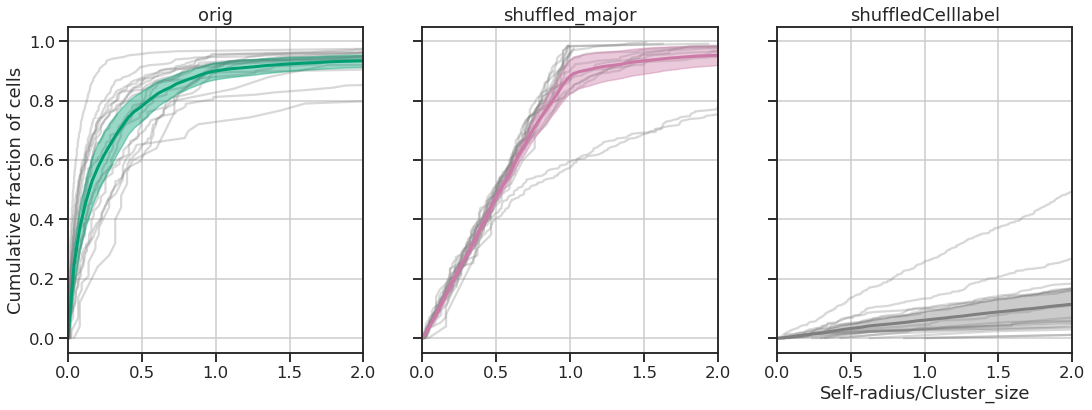

In [21]:
selected_data_pairs = collections.OrderedDict({
    key: data_pairs[key] for key in ['orig', 'shuffled_major', 'shuffledCelllabel']
})
colors = [
    palette_cluster_types['orig_major'], 
    palette_cluster_types['shuffled_major'],
    palette_cluster_types['shuffledCelllabel_major'],
]

cell_level_info_major, cluster_level_info_major = gather_self_radius_info(
                            choose_mod, metas[mod_j], cluster_col_major, 
                            selected_data_pairs, 
                            )
plot_self_radius(cell_level_info_major, colors,
                output=output_figures.format('plot_self_radius_cdf_groupby_majortypes', 'pdf'))

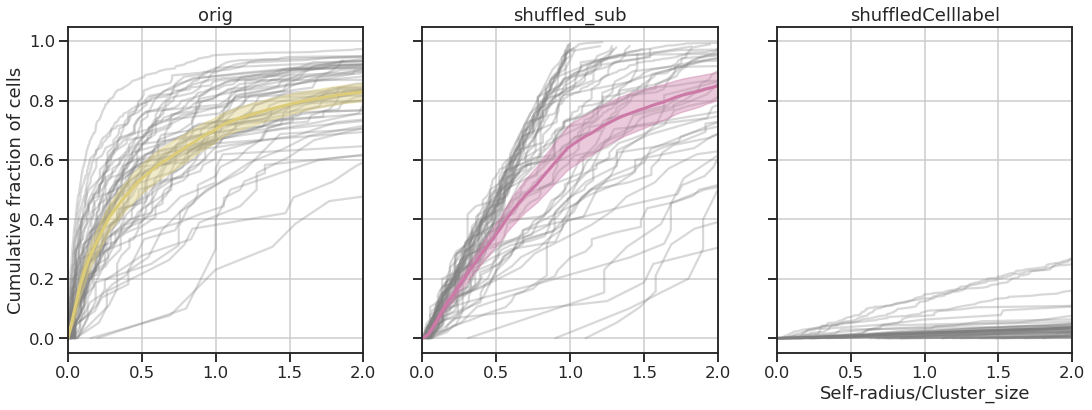

In [22]:
selected_data_pairs = collections.OrderedDict({
    key: data_pairs[key] for key in ['orig', 'shuffled_sub', 'shuffledCelllabel']
})
colors = [
    palette_cluster_types['orig_sub'], 
    palette_cluster_types['shuffled_sub'],
    palette_cluster_types['shuffledCelllabel_sub'],
]

cell_level_info_sub, cluster_level_info_sub = gather_self_radius_info(
                            choose_mod, metas[mod_j], cluster_col_sub, 
                            selected_data_pairs, 
                            )
plot_self_radius(cell_level_info_sub, colors,
                output=output_figures.format('plot_self_radius_cdf_groupby_subtypes', 'pdf'))

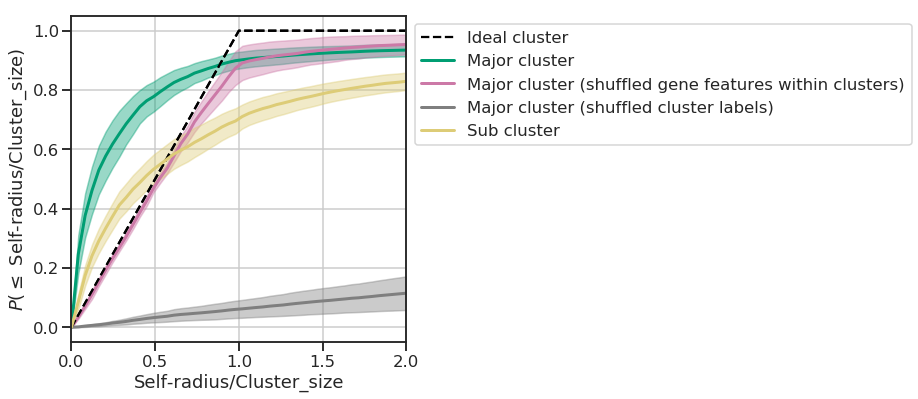

In [23]:
# summarize mean only
output = output_figures.format('plot_self_radius_cdf_mean_summary', 'pdf')

# plot
fig, ax = plt.subplots(1, 1, figsize=(6,6))

# plot grouped by major
xcols = [
    'n_self_radius_' + datapair_type
    for datapair_type in ['orig', 'shuffled_major', 'shuffledCelllabel']
]
xcol_names = [
    'Major cluster', 
    'Major cluster (shuffled gene features within clusters)', 
    'Major cluster (shuffled cluster labels)', 
    ]
colors = [
    palette_cluster_types['orig_major'], 
    palette_cluster_types['shuffled_major'], 
    palette_cluster_types['shuffledCelllabel_major'], 
]
plot_self_radius_mean(ax, cell_level_info_major, colors, xcols, xcol_names)

# plot grouped by sub 
xcols = [
    'n_self_radius_' + datapair_type
    for datapair_type in ['orig']
]
xcol_names = [
    'Sub cluster', 
    ]
colors = [
    palette_cluster_types['orig_sub'], 
]
plot_self_radius_mean(ax, cell_level_info_sub, colors, xcols, xcol_names)
# remove duplicated legend
general_utils.nondup_legends(bbox_to_anchor=(1,1))
# save
fig.savefig(output, bbox_inches='tight')
plt.show()


### Under-splitting evaluation. summarizing the above distributions into a cluster-level metric--undersplitting score

In [24]:
def plot_self_radius_cluster_level_metric(metric, baseline_level, datapair_type,  
                           cluster_level_info_major, cluster_level_info_sub, 
                           major_sub_lookup, color_major, color_sub, title='', output=''):
    """Plot cluster level metric (compare between major and sub clusters) for a given datapair type
    """
    nclsts = len(cluster_level_info_major)
    x = np.arange(nclsts)
    order = np.argsort(cluster_level_info_major[metric+'_'+datapair_type].values)
    xticks = cluster_level_info_major['clst_id'].values[order]
    y1 = cluster_level_info_major[metric+'_'+datapair_type].values[order]
    clsts = cluster_level_info_major['clst_id'].values[order]
    y2 = []
    y2_ticks = []
    for clst in clsts:
        _tmp = cluster_level_info_sub.set_index('clst_id').loc[major_sub_lookup[clst], metric+'_'+datapair_type]
        y2.append(_tmp.values)
        y2_ticks.append([clst.split('_')[-1] for clst in _tmp.index.values])
     
    scale = np.max([1, nclsts/30])
    fig, ax = plt.subplots(1, 1, figsize=(8*1,6*scale))
    ax.scatter(y1, x, zorder=2, color=color_major, label='Major cluster')
    ax.axvline(baseline_level, linestyle='--', linewidth=1, color='lightgray', zorder=1)
    for _x, _y1, _y2, _xtick, _ytick in zip(x, y1, y2, xticks, y2_ticks):
        miny = min([np.min(_y2), _y1])
        maxy = max([np.max(_y2), _y1])
        ax.plot([miny, maxy], [_x, _x], color='k', linewidth=1, zorder=0)
        ax.text(maxy+0.1, _x+0.1, _xtick, fontsize=12, 
                ha='left', va='center',
               )
        ax.scatter(_y2, [_x]*len(_y2), zorder=1, label='Sub cluster', 
                   s=40, color=color_sub, marker='o')
        
    ax.set_xlabel('Under-splitting score')
    ax.set_yticks([])
    general_utils.nondup_legends(ax, bbox_to_anchor=(0,1))
    ax.grid(False)
    sns.despine(ax=ax, left=True)
    ax.set_title(title)
    fig.tight_layout()
    
    if output:
        fig.savefig(output, bbox_inches='tight')
    plt.show()

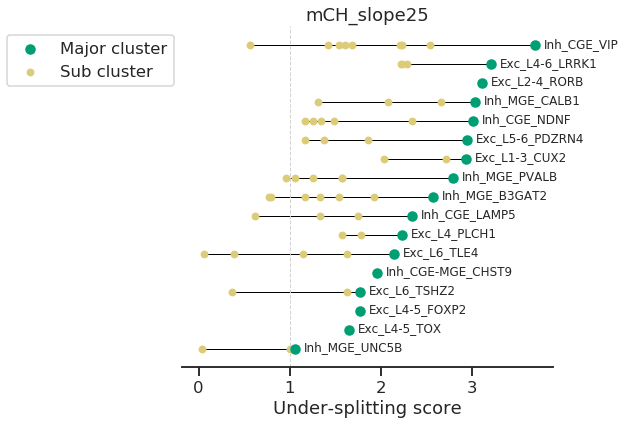

In [25]:
metric = 'slope25'
baseline_level = 1
title = 'mCH_slope25'
datapair_type = 'orig'

color_major = palette_cluster_types['orig_major']
color_sub = palette_cluster_types['orig_sub']
plot_self_radius_cluster_level_metric(
    metric, baseline_level, datapair_type,
    cluster_level_info_major, cluster_level_info_sub, 
    major_sub_lookup, color_major, color_sub,
    title=title,
    output=output_figures.format('plot_self_radius_cluster_level_major-{}'.format(title), 'pdf') 
    )

### Under-splitting evaluation--Plot the distributions of the fraction of k cross-modality neighbors from the same cluster as a function of k. 

In [26]:
def gather_knn_info(choose_mod, metadata, cluster_col, data_pairs):
    """knn for each i
    """
    cluster_lookup = metadata[cluster_col].values
    cluster_size_lookup = metadata[[cluster_col]].groupby(cluster_col).size()
    nclsts = len(np.unique(cluster_lookup))
    ncells = len(cluster_lookup)
    frac_knn_clst_size = np.sort(np.unique(np.hstack([
                                                    np.linspace(0, 1, 11), 
                                                    np.linspace(1, 4, 16), 
                                                   ])))[1:]
    knn_cluster_level_dist_alldatapairs = collections.OrderedDict({})
    for datapair_type, data_pair in data_pairs.items():
        # get knn_mat
        if choose_mod == 'mod_i':
            knn_mat = data_pair.knn_ij_grand 
        elif choose_mod == 'mod_j':
            knn_mat = data_pair.knn_ji_grand 
        else:
            raise ValueError('Choose from mod_i and mod_j')
            
        knn_cluster_level_dist = []
        for frac_knn in frac_knn_clst_size:
            knn_clsts = (frac_knn*cluster_size_lookup).astype(int)
            # evaluate i
            nagree_i = {}
            for row_idx in np.arange(ncells):
                row_clst = cluster_lookup[row_idx]
                if row_clst not in nagree_i.keys():
                    nagree_i[row_clst] = 0
                row_clst_size = cluster_size_lookup[row_clst]
                row = knn_mat[row_idx, :][:knn_clsts[row_clst]]
                nagree_i[row_clst] += (cluster_lookup[row] == cluster_lookup[row_idx]).astype(int).sum()/(row_clst_size*knn_clsts[row_clst])
            knn_cluster_level_dist.append(nagree_i)

        knn_cluster_level_dist = pd.DataFrame(knn_cluster_level_dist, index=frac_knn_clst_size) 
        knn_cluster_level_dist.index.name = 'frac_knn_clst_size'
        # add it into the dictionary
        knn_cluster_level_dist_alldatapairs[datapair_type] = knn_cluster_level_dist
    
    
    x = np.linspace(1, 4, 30)
    y = 1/x
    x = np.hstack([[0, 1], x])
    y = np.hstack([[1, 1], y])
    area_ref = compute_area(x, y, 0, 4)
    
    
    knn_cluster_level_stats_alldatapairs = collections.OrderedDict({})
    for datapair_type, data_pair in data_pairs.items():
        knn_cluster_level_stats = []
        knn_cluster_level_dist = knn_cluster_level_dist_alldatapairs[datapair_type]
        for clst_id in knn_cluster_level_dist.columns:
            clst_size = cluster_size_lookup[clst_id]
            x = frac_knn_clst_size 
            y = knn_cluster_level_dist[clst_id].values
            area = compute_area(x, y, 0, 4)/area_ref
            y1 = 1 - np.interp(1, x, y)
            knn_cluster_level_stats.append({
                'clst_id': clst_id, 
                'clst_size': clst_size,
                'area': area, 
                'y1': y1,
                })
        knn_cluster_level_stats = pd.DataFrame(knn_cluster_level_stats)
        knn_cluster_level_stats_alldatapairs[datapair_type] = knn_cluster_level_stats
    
    return knn_cluster_level_dist_alldatapairs, knn_cluster_level_stats_alldatapairs

def plot_knn_distribution(knn_cluster_level_dist_alldatapairs, metadata, cluster_col, colors, output=''):
    """"""
    cluster_size_lookup = metadata[[cluster_col]].groupby(cluster_col).size()
    nclsts = len(cluster_size_lookup)
    ndatapairs = len(knn_cluster_level_dist_alldatapairs)
    
    fig, axs = plt.subplots(1, ndatapairs, figsize=(5*ndatapairs,5), sharex=True, sharey=True)
    for i, (ax, datapair_type, color) in enumerate(zip(
                                                axs, knn_cluster_level_dist_alldatapairs.keys(), colors)):
        knn_cluster_level_dist_alldatapair = knn_cluster_level_dist_alldatapairs[datapair_type]
        frac_knn_clst_size = knn_cluster_level_dist_alldatapair.index.values 
        x = np.linspace(1, 4, 30)
        y = 1/x
        x = np.hstack([[0, 1], x])
        y = np.hstack([[1, 1], y])
        ax.plot(x, y, '--', 
                color='k', 
               )

        ys = []
        for clst_id in knn_cluster_level_dist_alldatapair.columns:
            x = frac_knn_clst_size 
            y = knn_cluster_level_dist_alldatapair[clst_id].values
            ax.plot(x, y, '-', 
                    color='grey', alpha=0.4, zorder=1,
                   )
            ys.append(y)
        ys = np.array(ys)
        y_mean = ys.mean(axis=0)
        y_err = 1.96*ys.std(axis=0)/np.sqrt(nclsts)

        ax.plot(x, y_mean, color=color, zorder=2, linewidth=3)
        ax.fill_between(x, 
                        y_mean-y_err, 
                        y_mean+y_err, 
                        color=color, alpha=0.4, zorder=2)
        ax.xaxis.set_major_locator(mtick.MaxNLocator(5))

        if i == 0:
            ax.set_xlabel('Number of neighbors/Cluster size')
            ax.set_ylabel('Fraction of neighbors\nfrom the same cell type (n={})'.format(nclsts))
        else:
            ax.set_xlabel('')
            ax.set_ylabel('')
            
        ax.set_title(datapair_type)
        ax.set_xlim([-0.01, 2.01])
    
    if output:
        fig.savefig(output, bbox_inches='tight')
    plt.show()
    return 

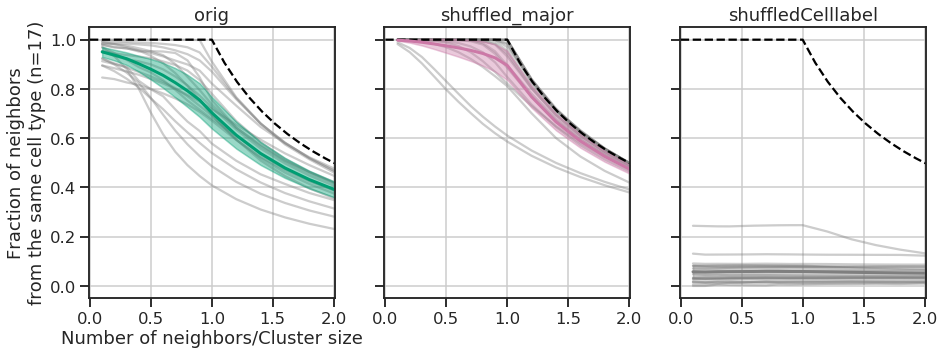

In [27]:
choose_mod = 'mod_j'
selected_data_pairs = collections.OrderedDict({
    key: data_pairs[key] for key in ['orig', 'shuffled_major', 'shuffledCelllabel']
})
colors = [
    palette_cluster_types['orig_major'], 
    palette_cluster_types['shuffled_major'],
    palette_cluster_types['shuffledCelllabel_major'],
]

knn_cluster_level_dist_alldatapairs_major, knn_cluster_level_stats_alldatapairs_major = gather_knn_info(
                choose_mod, metas[mod_j], cluster_col_major, 
                selected_data_pairs)
plot_knn_distribution(knn_cluster_level_dist_alldatapairs_major, metas[mod_j], cluster_col_major, colors, 
          output=output_figures.format('plot_knn_distribution_groupby_majortypes'.format(title), 'pdf'))

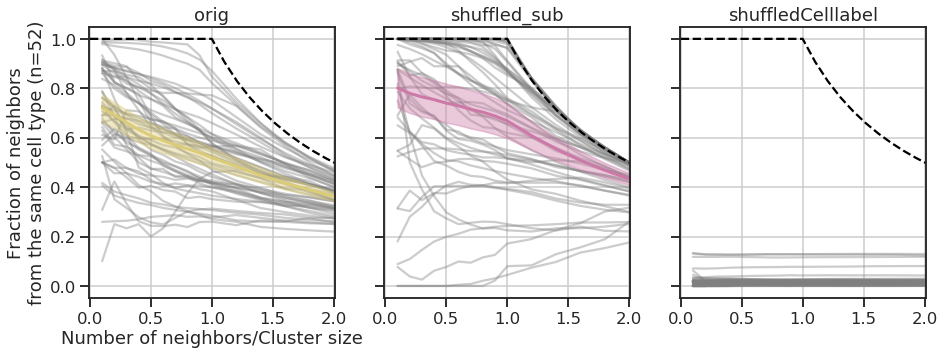

In [28]:
choose_mod = 'mod_j'
selected_data_pairs = collections.OrderedDict({
    key: data_pairs[key] for key in ['orig', 'shuffled_sub', 'shuffledCelllabel']
})
colors = [
    palette_cluster_types['orig_sub'], 
    palette_cluster_types['shuffled_sub'],
    palette_cluster_types['shuffledCelllabel_sub'],
]

knn_cluster_level_dist_alldatapairs_sub, knn_cluster_level_stats_alldatapairs_sub = gather_knn_info(
                choose_mod, metas[mod_j], cluster_col_sub, 
                selected_data_pairs)
plot_knn_distribution(knn_cluster_level_dist_alldatapairs_sub, metas[mod_j], cluster_col_sub, colors, 
          output=output_figures.format('plot_knn_distribution_groupby_subtypes'.format(title), 'pdf'))

In [29]:
def plot_knn_distribution_mean(ax, metadata, cluster_col, 
                               knn_cluster_level_dist_alldatapairs, colors, labels, 
                               output=''):
    """
    """
    cluster_size_lookup = metadata[[cluster_col]].groupby(cluster_col).size()
    nclsts = len(cluster_size_lookup)
    ndatapairs = len(knn_cluster_level_dist_alldatapairs)
    
    x = np.linspace(1, 4, 30)
    y = 1/x
    x = np.hstack([[0, 1], x])
    y = np.hstack([[1, 1], y])
    ax.plot(x, y, '--', 
            color='k', 
            label='Ideal cluster'
           )
    
    for i, (datapair_type, color, label) in enumerate(zip(
                                knn_cluster_level_dist_alldatapairs.keys(), colors, labels)):
        knn_cluster_level_dist = knn_cluster_level_dist_alldatapairs[datapair_type]
        frac_knn_clst_size = knn_cluster_level_dist.index.values 
        ys = []
        for clst_id in knn_cluster_level_dist.columns:
            x = frac_knn_clst_size 
            y = knn_cluster_level_dist[clst_id].values
            ys.append(y)

        ys = np.array(ys)
        y_mean = ys.mean(axis=0)
        y_err = 1.96*ys.std(axis=0)/np.sqrt(nclsts)

        ax.plot(x, y_mean, color=color, zorder=2, linewidth=3, label=label)
        ax.fill_between(x, 
                        y_mean-y_err, 
                        y_mean+y_err, 
                        color=color, alpha=0.4, zorder=2)
        ax.xaxis.set_major_locator(mtick.MaxNLocator(5))

        ax.set_xlabel('Number of neighbors/Cluster size')
        ax.set_ylabel('Fraction of neighbors\nfrom the same cell type'.format(nclsts))
        ax.set_xlim([-0.01, 2.01])
    return 


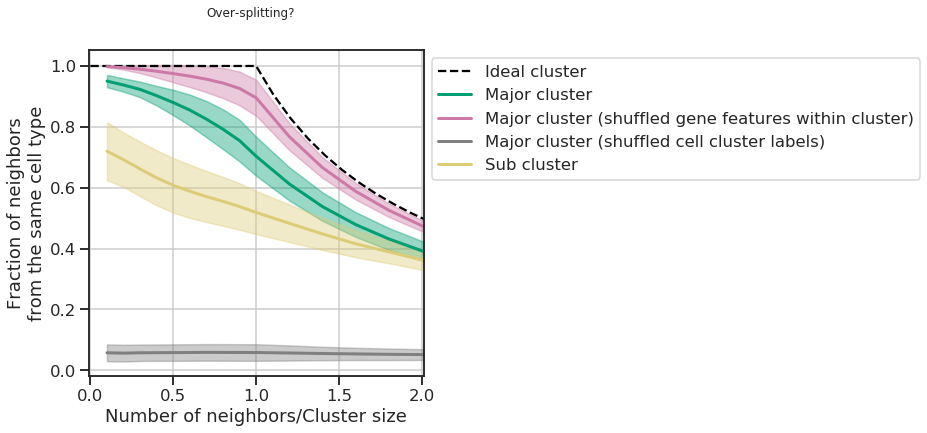

In [30]:
output = output_figures.format('plot_knn_distribution_mean', 'pdf') 

# 4 results
knn_cluster_level_dist_selected_datapairs = collections.OrderedDict({
    k: knn_cluster_level_dist_alldatapairs_major[k] for k in ['orig', 'shuffled_major', 'shuffledCelllabel']
}) 
knn_cluster_level_dist_selected_datapairs['orig_sub'] = knn_cluster_level_dist_alldatapairs_sub['orig'] 
    
labels = [
    'Major cluster',
    'Major cluster (shuffled gene features within cluster)',
    'Major cluster (shuffled cell cluster labels)',
    'Sub cluster',
]
colors = [
    palette_cluster_types['orig_major'],
    palette_cluster_types['shuffled_major'],
    palette_cluster_types['shuffledCelllabel_major'],
    palette_cluster_types['orig_sub'],
]



fig, ax = plt.subplots(1, 1, figsize=(6*1,6))
plot_knn_distribution_mean(ax, metas[mod_j], cluster_col_major, 
                           knn_cluster_level_dist_selected_datapairs, colors, labels, 
                           output=output)
general_utils.nondup_legends(ax, bbox_to_anchor=(1,1))
fig.suptitle('Over-splitting?')
if output:
    fig.savefig(output, bbox_inches='tight')

### Over-splitting evaluation. summarizing the above distributions into a cluster-level metric--oversplitting score

In [31]:
def plot_knn_cluster_level_metric(metric, baseline_level, 
                        knn_cluster_level_stats_major, knn_cluster_level_stats_sub, 
                        major_sub_lookup, metadata, 
                        cluster_col_major, cluster_col_sub,
                        color_major, color_sub,
                        title='', output=''):
    """
    """
    dot_size = 200
    cluster_size_lookup_major = metadata[[cluster_col_major]].groupby(cluster_col_major).size()
    cluster_size_lookup_sub = metadata[[cluster_col_sub]].groupby(cluster_col_sub).size()
    
    nclsts = len(knn_cluster_level_stats_major)
    x = np.arange(nclsts)
    order = np.argsort(knn_cluster_level_stats_major[metric].values) #[::-1]
    xticks = knn_cluster_level_stats_major['clst_id'].values[order]
    y1 = knn_cluster_level_stats_major[metric].values[order]
    clsts = knn_cluster_level_stats_major['clst_id'].values[order]
    y2 = []
    y2_ticks = []
    y2_size = []
    for clst in clsts:
        _tmp = knn_cluster_level_stats_sub.set_index('clst_id').loc[major_sub_lookup[clst], metric]
        y2.append(_tmp.values)
        y2_ticks.append([clst.split('_')[-1] for clst in _tmp.index.values])
        y2_size.append(cluster_size_lookup_sub[_tmp.index.values])
     
    scale = np.max([1, nclsts/30])
    fig, ax = plt.subplots(1, 1, figsize=(8*1,6*scale))
    ax.axvline(baseline_level, linestyle='--', linewidth=1, color='lightgray', zorder=1)
    ax.scatter(y1, x, zorder=2, s=dot_size, color=color_major, label='Major cluster')
    for _x, _y1, _y2, _xtick, _ytick, _y2_size in zip(x, y1, y2, xticks, y2_ticks, y2_size):
        miny = min([np.min(_y2), _y1])
        maxy = max([np.max(_y2), _y1])
        ax.plot([miny, maxy], [_x, _x], color='k', linewidth=1, zorder=0)
        ax.text(miny-0.02, _x+0.1, _xtick, fontsize=12, 
                ha='right', va='center',
               )
        ax.scatter(_y2, [_x]*len(_y2), s=dot_size*_y2_size/np.sum(_y2_size), 
                   zorder=1, label='Sub cluster', 
                   color=color_sub, marker='o')
        
    ax.set_xlabel('Over-splitting score')
    ax.set_yticks([])
    ax.grid(False)
    ax.set_xlim([-0.01, 1.01])
    sns.despine(ax=ax, left=True)
    ax.set_title(title)
    fig.tight_layout()
    
    if output:
        fig.savefig(output, bbox_inches='tight')
    plt.show()

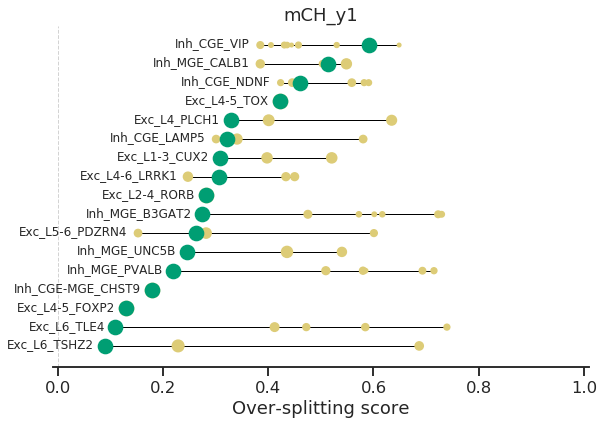

In [32]:
metric = 'y1'
title = 'mCH_{}'.format(metric)

color_major = palette_cluster_types['orig_major']
color_sub = palette_cluster_types['orig_sub']
baseline_level = 0

plot_knn_cluster_level_metric(
                    metric, baseline_level, 
                    knn_cluster_level_stats_alldatapairs_major['orig'], 
                    knn_cluster_level_stats_alldatapairs_sub['orig'], 
                    major_sub_lookup, metas[mod_j], 
                    cluster_col_major, cluster_col_sub,
                    color_major, color_sub,
                    title=title, 
                    output=output_figures.format('plot_oversplit_cluster_level_{}'.format(title), 'pdf')) 

### Combining both metrics--an illustration of the trade-off between the under- and over-splitting

In [33]:
combined_metrics = []
metric_undersplit = 'slope25'
metric_oversplit = 'y1'

for datapair_type in ['orig', 'shuffled_major', 'shuffledCelllabel']:
    _df = cluster_level_info_major[
        ['clst_id', 'cluster_size', metric_undersplit+'_'+datapair_type]
        ].rename(columns={metric_undersplit+'_'+datapair_type: metric_undersplit})
    
    _df2 = knn_cluster_level_stats_alldatapairs_major[datapair_type][
        ['clst_id', metric_oversplit]
    ]
    _df = pd.merge(_df, _df2, on='clst_id')
    if datapair_type.endswith('_major'):
        _df['cluster_type'] = datapair_type
    else:
        _df['cluster_type'] = datapair_type + '_major'
    combined_metrics.append(_df)

for datapair_type in ['orig', 'shuffled_sub', 'shuffledCelllabel']:
    _df = cluster_level_info_sub[
        ['clst_id', 'cluster_size', metric_undersplit+'_'+datapair_type]
        ].rename(columns={metric_undersplit+'_'+datapair_type: metric_undersplit})
    
    _df2 = knn_cluster_level_stats_alldatapairs_sub[datapair_type][
        ['clst_id', metric_oversplit]
    ]
    _df = pd.merge(_df, _df2, on='clst_id')
    if datapair_type.endswith('_sub'):
        _df['cluster_type'] = datapair_type
    else:
        _df['cluster_type'] = datapair_type + '_sub'
    combined_metrics.append(_df)
        
combined_metrics = pd.concat(combined_metrics)
print(combined_metrics.shape)
combined_metrics.head()


(207, 5)


,clst_id,cluster_size,slope25,y1,cluster_type
0,Exc_L1-3_CUX2,928,2.935345,0.308155,orig_major
1,Exc_L2-4_RORB,512,3.109375,0.281857,orig_major
2,Exc_L4-5_FOXP2,280,1.771429,0.129503,orig_major
3,Exc_L4-5_TOX,43,1.651163,0.421850,orig_major
4,Exc_L4-6_LRRK1,312,3.205128,0.306511,orig_major


In [34]:
# save combined metrics
combined_metrics.head()
f = './results/combined_metrics_{}.tsv'.format(name)
combined_metrics.to_csv(f)

-1.84578326164 2.56327038895 -0.393778288429 0.000815259454084


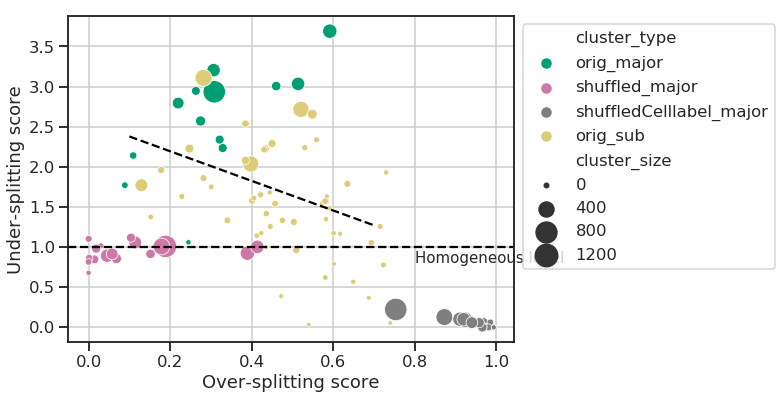

In [35]:
output = output_figures.format('plot_scatter_combined_metrics', 'pdf') 
plot_types = ['orig_major', 'orig_sub', 'shuffledCelllabel_major', 'shuffled_major']
scale=0.8

fig, ax = plt.subplots(1, 1, figsize=(8*1,6))
sns.scatterplot(x=metric_oversplit, y=metric_undersplit, 
                hue='cluster_type',
                size='cluster_size', 
                sizes=(20,500),
#                 size_norm=(0, 1000),
                palette=palette_cluster_types,
                data=combined_metrics[combined_metrics['cluster_type'].isin(plot_types)], 
                ax=ax)
ax.axhline(1, linestyle='--', color='black')
ax.text(0.8, 0.8, 'Homogeneous level', fontsize=15)

x = combined_metrics[combined_metrics['cluster_type'].isin(['orig_major', 'orig_sub'])]
_x = x[metric_oversplit]
_y = x[metric_undersplit]
k, b, r, p, stderr = stats.linregress(_x, _y)
print(k, b, r, p)
_x = np.linspace(0.1, 0.7, 10)
_y = k*_x + b
ax.plot(_x, _y, linestyle='--', color='k')

ax.set_xlabel('Over-splitting score')
ax.set_ylabel('Under-splitting score')
# ax.set_xlim([-0.02, 1.02])
# ax.set_ylim([-0.02, 1.02])
ax.legend(bbox_to_anchor=(1,1),)
fig.savefig(output, bbox_inches='tight')
plt.show()